In [49]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import mnist

In [67]:
import matplotlib.pyplot as plt

In [50]:
from google.colab.patches import cv2_imshow

In [51]:
import struct

In [52]:
from array import array

In [53]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary_image = cv2.adaptiveThreshold(
        gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    denoised_image = cv2.medianBlur(binary_image, 3)
    cv2_imshow(denoised_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return denoised_image

In [54]:
def segment_characters(binary_image, output_dir="segmented_characters"):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    os.makedirs(output_dir, exist_ok=True)
    char_images = []
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        if w > 10 and h > 10:  # Filter noise
            char_image = binary_image[y:y+h, x:x+w]
            char_path = os.path.join(output_dir, f"char_{i}.png")
            cv2.imwrite(char_path, char_image)
            char_images.append(char_image)
            print(f"Segmented character {i}: {x}, {y}, {w}, {h}")
            cv2_imshow(char_image)  # Visualize each segmented character
    if not char_images:
        raise ValueError("No characters were segmented.")
    return sorted(char_images, key=lambda img: cv2.boundingRect(img)[0])

In [55]:
# def extract_features(char_image):
#     resize_image = cv2.resize(char_image, (28, 28))
#     # Normalize pixel values
#     feature_vector = resize_image.flatten() / 255.0
#     return feature_vector

In [56]:
# def knn(train_data,train_labels,test_data,k=3):
#     distance=np.linalg.norm(train_data-test_data,axis=1)
#     sorted_indices=np.argsort(distance)
#     top_k_labels=train_labels[sorted_indices[:k]]
#     return np.bincount(top_k_labels).argmax()

In [57]:
# def perform_ocr(image_path,train_data,train_labels):
#     denoised_binary_image=preprocess_image(image_path)
#     char_images=segment_characters(denoised_binary_image)
#     predictions=[]
#     for char_image in char_images:
#         features=extract_features(char_image)
#         prediction=knn(np.array(train_data),np.array(train_labels),features)
#         predictions.append(prediction)

#     return predictions

In [58]:
#Creating a dummy dataset
# train_data=[]
# train_labels=[]
# for i in range(10):
#     dummy_image=np.zeros((28,28),dtype=np.uint8)
#     cv2.putText(dummy_image,str(i),(5,23),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255),2)
#     # cv2.imshow('Character',dummy_image)
#     # cv2.waitKey(0)
#     train_data.append(dummy_image.flatten())
#     train_labels.append(i)

In [59]:
# # Load the MNIST dataset
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# # Normalize the pixel values (scale to range 0-1)
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0

# # Reshape the data for use with fully connected layers (flatten images)
# train_data = x_train.reshape(x_train.shape[0], -1)
# test_data = x_test.reshape(x_test.shape[0], -1)

# # Print the shapes of the data
# print("Training data shape:", train_data.shape)
# print("Training labels shape:", y_train.shape)
# print("Test data shape:", test_data.shape)
# print("Test labels shape:", y_test.shape)

# # Now you can use train_data, y_train, test_data, and y_test for your OCR or any other application


Since KNN is not working well in detecting curves

In [60]:
# #Testing the OCR
# image_path="3.png"
# predicted_labels=perform_ocr(image_path,train_data,y_train)
# print(f"Predicted Text : {''.join(map(str,predicted_labels))}")

Using CNN for OCR for a better understanding of Curves and Edges

In [61]:
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')  # 10 classes for digits 0-9
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [62]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values and reshape
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)  # Add channel dimension
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Build and train the CNN
cnn_model = build_cnn_model()
cnn_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.8942 - loss: 0.3468 - val_accuracy: 0.9841 - val_loss: 0.0485
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 79s 56ms/step - accuracy: 0.9850 - loss: 0.0499 - val_accuracy: 0.9873 - val_loss: 0.0394
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 54s 58ms/step - accuracy: 0.9899 - loss: 0.0332 - val_accuracy: 0.9863 - val_loss: 0.0399
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 79s 55ms/step - accuracy: 0.9925 - loss: 0.0235 - val_accuracy: 0.9908 - val_loss: 0.0265
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 56ms/step - accuracy: 0.9942 - loss: 0.0183 - val_accuracy: 0.9895 - val_loss: 0.0311


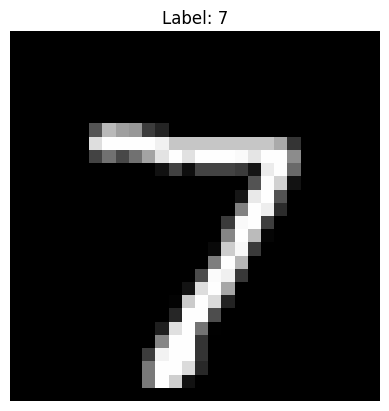

In [68]:
example_image = x_test[0]
example_label = y_test[0]

# Save the example image as a PNG file for testing
import cv2
cv2.imwrite('mnist_example.png', example_image)

# Display the image and its label
plt.imshow(example_image, cmap='gray')
plt.title(f"Label: {example_label}")
plt.axis('off')
plt.show()

In [63]:
def perform_ocr_with_cnn(image_path, cnn_model):
    denoised_binary_image = preprocess_image(image_path)  # Preprocess the input image
    char_images = segment_characters(denoised_binary_image)  # Segment characters
    predictions = []
    for char_image in char_images:
        # Resize the character to 28x28 while preserving the aspect ratio
        h, w = char_image.shape
        if h > w:
            scale = 28 / h
            new_h, new_w = 28, int(w * scale)
        else:
            scale = 28 / w
            new_h, new_w = int(h * scale), 28

        resized_char = cv2.resize(char_image, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Pad the resized character to make it 28x28
        padded_char = np.pad(
            resized_char,
            ((0, 28 - resized_char.shape[0]), (0, 28 - resized_char.shape[1])),
            mode='constant',
            constant_values=0
        )

        # Normalize pixel values
        normalized_char = padded_char.astype('float32') / 255.0
        normalized_char = normalized_char.reshape(1, 28, 28, 1)  # Add batch and channel dimensions

        # Predict the character using the CNN model
        probabilities = cnn_model.predict(normalized_char)
        prediction = np.argmax(probabilities, axis=1)[0]
        confidence = probabilities[0][prediction]
        print(f"Predicted: {prediction}, Confidence: {confidence:.2f}")
        predictions.append(prediction)

    return predictions

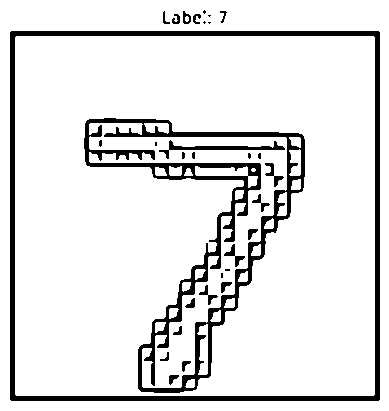

Segmented character 0: 0, 0, 389, 411


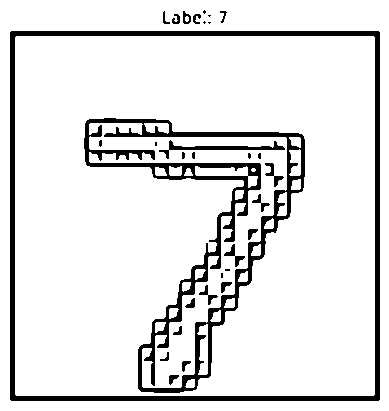

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted: 0, Confidence: 0.25
Predicted Text: 0


In [69]:
# Test the CNN-based OCR
image_path = "7.png"  # Input image path
predicted_labels = perform_ocr_with_cnn(image_path, cnn_model)
print(f"Predicted Text: {''.join(map(str, predicted_labels))}")